In [51]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda, dot, Activation, concatenate,  Layer, Embedding, Bidirectional
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from sklearn.utils import resample

In [128]:
df = pd.read_csv("datafiltered.csv")
df= df.drop_duplicates('id')

RANDOM_SEED = 42
normal = df[df.sentiment == 0]
depressed = df[df.sentiment == 1 ]
print(normal.shape)
print(depressed.shape)
normal_downsampled = resample(normal, replace = False, n_samples = len(df[df['sentiment'] == 1]), random_state = RANDOM_SEED)
df = pd.concat([depressed, normal_downsampled])
df.sentiment.value_counts()
df= df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df.head())
print(df.shape)

(51, 4)
(48, 4)
             id                       date  \
0  1.352252e+18  2021-01-21 13:48:59+00:00   
1  1.352261e+18  2021-01-21 14:25:02+00:00   
2  1.352285e+18  2021-01-21 15:59:21+00:00   
3  1.352489e+18  2021-01-22 05:32:57+00:00   
4  1.252660e+18  2020-04-21 18:17:18+00:00   

                                               tweet  sentiment  
0  Hope everyone has an amazing day filled with p...          0  
1  A positive mindset will find positivity in alm...          0  
2  “An attitude of gratitude expands like latitud...          0  
3  Sometimes you just gotta smile and push throug...          0  
4  being depressed for no reason isn’t always tru...          1  
(96, 4)


In [129]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string 

def processTweet(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'$\w*', '', tweet)
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ') 
    tweet = re.sub('https', ' ', tweet)
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

x = list(df['tweet'])
for i in range(0,len(x)):
  x[i] = processTweet(x[i])

df['tweet'] = x

tokenizer = RegexpTokenizer(r'\w+')
regexptokenized = []
for i in list(df['tweet']):
  regexptokenized.append(tokenizer.tokenize(i))
#tokenizedtweet = tokenizer.tokenize(list(df['tweet']))
print(regexptokenized[0:5])
tokenized = []


filtered_words = [word for word in regexptokenized if word not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[['hope', 'everyone', 'has', 'amazing', 'day', 'filled', 'with', 'positive', 'vibes', 'never', 'forget', 'your', 'true', 'self', 'shine', 'smile', 'never', 'give', 'positivity', 'goodvibesonly', 'twitch', 'twitchaffiliate', 'xbox', 'canadian'], ['positive', 'mindset', 'will', 'find', 'positivity', 'almost', 'anything', 'there', 'always', 'positivity', 'positive', 'message', 'even', 'the', 'utmost', 'negative', 'circumstance', 'scenario', 'peace', 'perception', 'positivity', 'lifelessons'], ['attitude', 'gratitude', 'expands', 'like', 'latitude', 'and', 'longitude', 'jordan', 'mendoza', 'who', 'are', 'you', 'grateful', 'for', 'today', 'tag', 'them', 'below', 'and', 'let', 'them', 

In [130]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stringcontent = ""
newcontent = []
for i in filtered_words:
  stringcontent = ""
  for j in i:
    stringcontent += lemmatizer.lemmatize(j) + " " 
  newcontent.append(stringcontent)
df['tweet'] = newcontent

In [131]:
from sklearn.model_selection import train_test_split

In [132]:
epochs = 10
embed_size = 200
batch_size = 16
maxlen = 75
vocab_size = 35000

In [133]:
EMBEDDING_FILE = 'F:/ASDRP/src/models/textclassification/glove.twitter.27B.200d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8" ))

In [134]:
X = df.tweet.values 
y = df.sentiment.values
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen = maxlen)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [135]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) + 1
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i > vocab_size: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [136]:
embedding_matrix.shape

(730, 200)

In [137]:
epochs = 10
embed_size = 200
batch_size = 16

In [138]:
class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [139]:
model = Sequential()
model.add(Embedding(nb_words, output_dim=embed_size, input_length= maxlen, weights = [embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(units=128)))
#model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [140]:
my_callback = MyThresholdCallback(threshold=0.95)
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test, y_test) , epochs = 5, callbacks = [my_callback])

Epoch 1/5
5/5 [==============================] - 13s 928ms/step - loss: 0.7921 - tp: 2.0000 - fp: 12.0000 - tn: 14.1667 - fn: 20.8333 - accuracy: 0.3011 - precision: 0.1442 - recall: 0.1369 - auc: 0.3420 - val_loss: 0.5491 - val_tp: 16.0000 - val_fp: 6.0000 - val_tn: 7.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.7931 - val_precision: 0.7273 - val_recall: 1.0000 - val_auc: 0.9688
Epoch 2/5
5/5 [==============================] - 1s 237ms/step - loss: 0.5252 - tp: 24.0000 - fp: 3.0000 - tn: 22.0000 - fn: 0.0000e+00 - accuracy: 0.9384 - precision: 0.8889 - recall: 1.0000 - auc: 0.9877 - val_loss: 0.4673 - val_tp: 15.0000 - val_fp: 1.0000 - val_tn: 12.0000 - val_fn: 1.0000 - val_accuracy: 0.9310 - val_precision: 0.9375 - val_recall: 0.9375 - val_auc: 0.9808
Epoch 3/5
5/5 [==============================] - 1s 210ms/step - loss: 0.4156 - tp: 22.3333 - fp: 1.0000 - tn: 25.0000 - fn: 0.6667 - accuracy: 0.9623 - precision: 0.9420 - recall: 0.9770 - auc: 0.9841 - val_loss: 0.3609 - val_tp: 16.000

In [145]:
model.save("modelGLOVE9655only100.h5") 

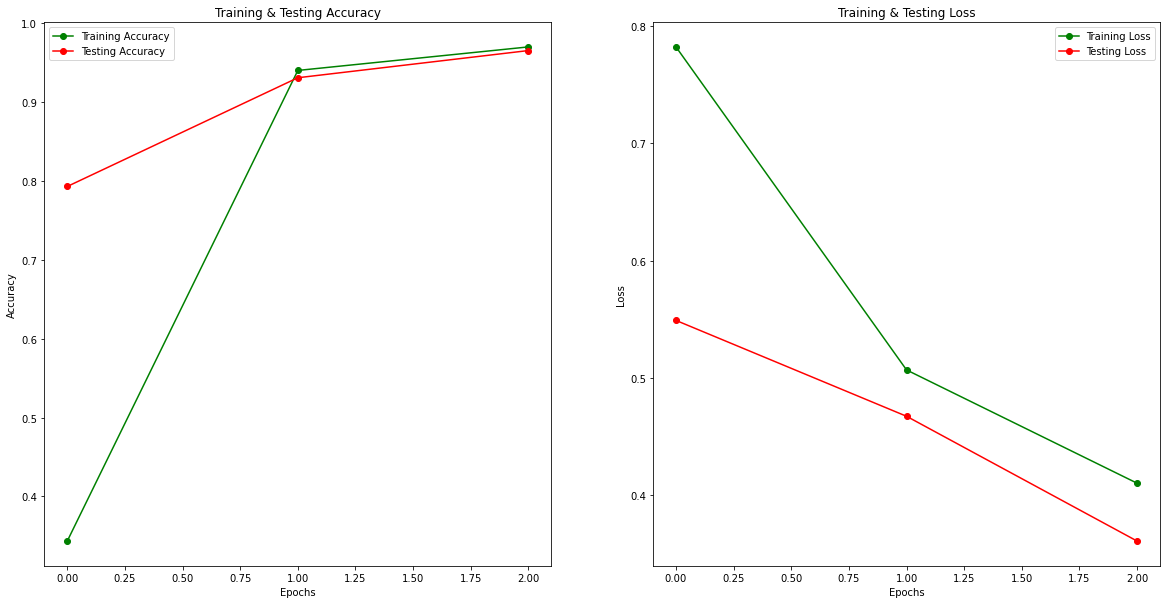

In [142]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [143]:
predicted = (model.predict(X_test) >= 0.5).astype("int")
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.94      1.00      0.97        16

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.96        29
weighted avg       0.97      0.97      0.97        29



<AxesSubplot:>

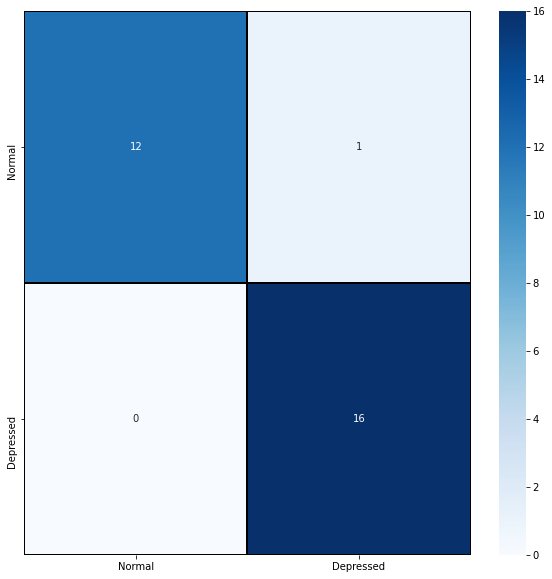

In [144]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predicted)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['Normal','Depressed'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal','Depressed'] , yticklabels = ['Normal','Depressed'])

In [146]:
import nltk 
nltk.download('words')
words = set(nltk.corpus.words.words())
filtered = []
for i in list(word_index.keys()):
    filtered.append("".join([w for w in i if w in words]))
with open('word_index2.txt', 'w') as f:
    for item in filtered:
        f.write("%s\n" % item)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [31]:
model = tensorflow.keras.models.load_model("modelGLOVE9047.h5")

In [49]:
def processData(text):
    def processTweet(tweet):
        tweet = re.sub(r'\&\w*;', '', tweet)
        tweet = re.sub('@[^\s]+','',tweet)
        tweet = re.sub(r'\$\w*', '', tweet)
        tweet = tweet.lower()
        tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
        tweet = re.sub(r'#\w*', '', tweet)
        tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
        tweet = re.sub(r'\s\s+', ' ', tweet)
        tweet = tweet.lstrip(' ') 
        tweet = re.sub('https', ' ', tweet)
        tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
        return tweet

    stop_words = set(stopwords.words('english'))  

    text = processTweet(text)
    word_tokens = RegexpTokenizer(r'\w+').tokenize(text)
    text = [word for word in word_tokens if not word in stop_words]
    return " ".join([str(x) for x in text])
maxlen = 75
text = "i hate you and i hate me "
text = processData(text)
text_list = text.split(" ")
strings = open("word_index.txt").read()
newtext = " ".join([w for w in text_list if(w in strings)])
newtext = np.array([newtext])
t = Tokenizer()
t.fit_on_texts(newtext)
newX = t.texts_to_sequences(newtext)
newX = pad_sequences(newX)
classification = (model.predict(newX) >= 0.5).astype("int")
print(newtext)
print(classification)

['hate hate']
[[1]]
